In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for plotting
from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting
np.random.seed(1) #ensure reproducibility

pd.options.mode.chained_assignment = None  #hide any pandas warnings

In [2]:
# Data Cleaning

In [3]:
import pandas as pd
import numpy as np
import dame_flame
import random
import matplotlib.pyplot as plt

In [4]:
LIFT_reg = pd.read_csv("/Users/JennyH/cisil-causal-inference/Data/LIFT_registry.csv")

In [5]:
LIFT_reg.head()

,Age,RaceDesc,LanguageSpoken,CardIssuingAgency,FIPS,ExpirationDate,DateIssuedToCardHolder,Initial Load,Study Card,card_id
0,35,Black or African American,Other,KCMCCS,5.303303e+11,8/31/2019 0:00,2017-06-15 09:57:00,NaN,NaN,568-1
1,55,White,English,YWCA,5.303300e+11,7/31/2019 0:00,2017-06-05 14:04:00,NaN,NaN,2690-1
2,58,White,English,King County Public Health,5.303300e+11,11/30/2021 0:00,2019-08-28 13:47:00,NaN,NaN,2690-2
3,45,Asian,English,King County Public Health,5.303301e+11,5/31/2021 0:00,2019-06-30 17:47:00,NaN,NaN,2706-1
4,62,Asian,Chinese,Promo Account,5.303301e+11,3/31/2019 0:00,2017-03-31 16:25:00,NaN,NaN,2708-1


In [6]:
LIFT_reg.columns = [c.replace(' ', '_') for c in LIFT_reg.columns]

In [7]:
p1 = LIFT_reg[(LIFT_reg.Study_Card != "Subsidized Annual Pass") 
         & (LIFT_reg.Age >= 18) 
         & (LIFT_reg.DateIssuedToCardHolder >= "2019-03-01") 
         & (LIFT_reg.DateIssuedToCardHolder <= "2019-07-01") 
         & (LIFT_reg.CardIssuingAgency.isin(["CSO Auburn", "CSO Capitol Hill", "CSO White Center"]))]

In [8]:
p1 # 1368 rows

,Age,RaceDesc,LanguageSpoken,CardIssuingAgency,FIPS,ExpirationDate,DateIssuedToCardHolder,Initial_Load,Study_Card,card_id
158,50,American Indian or Alaska Native,English,CSO White Center,5.303301e+11,2/28/2022 0:00,2019-04-01 13:38:00,10,NaN,3228-1
364,66,White,English,CSO Capitol Hill,5.303301e+11,5/31/2021 0:00,2019-05-29 13:04:00,Passport,Phase1 Treatment,3970-2
1100,50,NaN,NaN,CSO Capitol Hill,5.303301e+11,2/28/2022 0:00,2019-04-26 13:55:00,10,NaN,6476-2
1232,64,White,English,CSO White Center,5.303303e+11,2/28/2022 0:00,2019-04-25 11:35:00,10,NaN,6950-1
2194,56,Black or African American,English,CSO Capitol Hill,5.303301e+11,10/31/2021 0:00,2019-05-13 11:43:00,10,NaN,10168-2
...,...,...,...,...,...,...,...,...,...,...
74865,23,Other,Other,CSO White Center,5.306105e+11,2/28/2022 0:00,2019-06-28 13:30:00,10,NaN,199252-1
74866,38,White,English,CSO White Center,5.303303e+11,2/28/2022 0:00,2019-06-28 13:35:00,10,NaN,199254-1
74868,65,Not Specified,English,CSO Capitol Hill,5.303301e+11,10/31/2021 0:00,2019-06-28 13:45:00,10,NaN,199258-1
74875,29,Not Specified,English,CSO Capitol Hill,NaN,10/31/2021 0:00,2019-06-28 14:23:00,10,NaN,199272-1


In [9]:
d = {"Passport":1, "10": 0}
p1['Initial_Load'] = p1['Initial_Load'].map(d)

In [10]:
# I bin all continuous variables.
p1['Age_bin']=pd.cut(x = p1['Age'],
                        bins = [17,25,35,45,55,65,100], 
                        labels = [0,1,2,3,4,5])

# I use one hot encoding for features with more than one category (ie smoking_status, work_type, age_bin)
prep_data = p1[['RaceDesc','LanguageSpoken', 'CardIssuingAgency']]
# prep_data
prep_data=pd.get_dummies(prep_data)
prep_data

p1.drop(columns=['RaceDesc','LanguageSpoken', 'CardIssuingAgency', "Study_Card"],inplace=True)

In [11]:
p1 # 1368

,Age,FIPS,ExpirationDate,DateIssuedToCardHolder,Initial_Load,card_id,Age_bin
158,50,5.303301e+11,2/28/2022 0:00,2019-04-01 13:38:00,0,3228-1,3
364,66,5.303301e+11,5/31/2021 0:00,2019-05-29 13:04:00,1,3970-2,5
1100,50,5.303301e+11,2/28/2022 0:00,2019-04-26 13:55:00,0,6476-2,3
1232,64,5.303303e+11,2/28/2022 0:00,2019-04-25 11:35:00,0,6950-1,4
2194,56,5.303301e+11,10/31/2021 0:00,2019-05-13 11:43:00,0,10168-2,4
...,...,...,...,...,...,...,...
74865,23,5.306105e+11,2/28/2022 0:00,2019-06-28 13:30:00,0,199252-1,0
74866,38,5.303303e+11,2/28/2022 0:00,2019-06-28 13:35:00,0,199254-1,2
74868,65,5.303301e+11,10/31/2021 0:00,2019-06-28 13:45:00,0,199258-1,4
74875,29,NaN,10/31/2021 0:00,2019-06-28 14:23:00,0,199272-1,1


In [12]:
p1 = p1.merge(prep_data,left_index=True, right_index=True,how='left')
p1

,Age,FIPS,ExpirationDate,DateIssuedToCardHolder,Initial_Load,card_id,Age_bin,RaceDesc_American Indian or Alaska Native,RaceDesc_Asian,RaceDesc_Black or African American,...,LanguageSpoken_Other,LanguageSpoken_Russian,LanguageSpoken_Somali,LanguageSpoken_Spanish,LanguageSpoken_Tagalog,LanguageSpoken_Tigrinya,LanguageSpoken_Vietnamese,CardIssuingAgency_CSO Auburn,CardIssuingAgency_CSO Capitol Hill,CardIssuingAgency_CSO White Center
158,50,5.303301e+11,2/28/2022 0:00,2019-04-01 13:38:00,0,3228-1,3,1,0,0,...,0,0,0,0,0,0,0,0,0,1
364,66,5.303301e+11,5/31/2021 0:00,2019-05-29 13:04:00,1,3970-2,5,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1100,50,5.303301e+11,2/28/2022 0:00,2019-04-26 13:55:00,0,6476-2,3,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1232,64,5.303303e+11,2/28/2022 0:00,2019-04-25 11:35:00,0,6950-1,4,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2194,56,5.303301e+11,10/31/2021 0:00,2019-05-13 11:43:00,0,10168-2,4,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74865,23,5.306105e+11,2/28/2022 0:00,2019-06-28 13:30:00,0,199252-1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
74866,38,5.303303e+11,2/28/2022 0:00,2019-06-28 13:35:00,0,199254-1,2,0,0,0,...,0,0,0,0,0,0,0,0,0,1
74868,65,5.303301e+11,10/31/2021 0:00,2019-06-28 13:45:00,0,199258-1,4,0,0,0,...,0,0,0,0,0,0,0,0,1,0
74875,29,NaN,10/31/2021 0:00,2019-06-28 14:23:00,0,199272-1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [13]:
p1.describe()

,Age,FIPS,Initial_Load,RaceDesc_American Indian or Alaska Native,RaceDesc_Asian,RaceDesc_Black or African American,RaceDesc_Hispanic or Latino,RaceDesc_Multi-Racial,RaceDesc_Native Hawaiian or Other Pacific Islander,RaceDesc_Not Specified,...,LanguageSpoken_Other,LanguageSpoken_Russian,LanguageSpoken_Somali,LanguageSpoken_Spanish,LanguageSpoken_Tagalog,LanguageSpoken_Tigrinya,LanguageSpoken_Vietnamese,CardIssuingAgency_CSO Auburn,CardIssuingAgency_CSO Capitol Hill,CardIssuingAgency_CSO White Center
count,1368.000000,1.297000e+03,1368.000000,1368.000000,1368.000000,1368.000000,1368.000000,1368.000000,1368.000000,1368.000000,...,1368.000000,1368.000000,1368.000000,1368.000000,1368.000000,1368.000000,1368.000000,1368.000000,1368.000000,1368.00000
mean,39.443713,5.303393e+11,0.135234,0.009503,0.046053,0.331140,0.070906,0.021199,0.024854,0.038012,...,0.030702,0.001462,0.002193,0.033626,0.002924,0.005117,0.001462,0.139620,0.301901,0.55848
std,13.543764,4.478080e+07,0.342098,0.097054,0.209676,0.470796,0.256762,0.144099,0.155736,0.191294,...,0.172572,0.038222,0.046795,0.180330,0.054014,0.071376,0.038222,0.346719,0.459250,0.49675
min,18.000000,5.303300e+11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,29.000000,5.303301e+11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,37.000000,5.303303e+11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000
75%,50.000000,5.303303e+11,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.00000
max,96.000000,5.306105e+11,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [14]:
# Deal with NULL values
# There are 201 null values for bmi. We will drop these values in the cell below.
p1.isnull().sum()

Age                                                    0
FIPS                                                  71
ExpirationDate                                         0
DateIssuedToCardHolder                                 0
Initial_Load                                           0
card_id                                                0
Age_bin                                                0
RaceDesc_American Indian or Alaska Native              0
RaceDesc_Asian                                         0
RaceDesc_Black or African American                     0
RaceDesc_Hispanic or Latino                            0
RaceDesc_Multi-Racial                                  0
RaceDesc_Native Hawaiian or Other Pacific Islander     0
RaceDesc_Not Specified                                 0
RaceDesc_Other                                         0
RaceDesc_White                                         0
LanguageSpoken_Chinese                                 0
LanguageSpoken_Dari            

In [15]:
#p1['Age_bin'].head()
#p1.iloc[[364], :]
p1[p1['Age_bin'].isna()]

,Age,FIPS,ExpirationDate,DateIssuedToCardHolder,Initial_Load,card_id,Age_bin,RaceDesc_American Indian or Alaska Native,RaceDesc_Asian,RaceDesc_Black or African American,...,LanguageSpoken_Other,LanguageSpoken_Russian,LanguageSpoken_Somali,LanguageSpoken_Spanish,LanguageSpoken_Tagalog,LanguageSpoken_Tigrinya,LanguageSpoken_Vietnamese,CardIssuingAgency_CSO Auburn,CardIssuingAgency_CSO Capitol Hill,CardIssuingAgency_CSO White Center


In [16]:
# Combine the Response-variable (sales) with the features (registry).
LIFT_s = pd.read_csv("/Users/JennyH/cisil-causal-inference/Data/LIFT_sales.csv")

In [17]:
LIFT_s.head()

,week,Txn Desc,loadings,Amount,card_id
0,2017-03-12,Purse,2,20.0,94262-1
1,2017-04-02,Purse,1,25.0,94262-1
2,2017-08-20,Purse,1,10.0,94262-1
3,2017-11-19,Pass,1,8.0,94262-1
4,2018-01-07,Pass,1,8.0,94262-1


In [19]:
LIFT_s_afterp1 = LIFT_s[(LIFT_s.week >= "2019-09-01")]
LIFT_s_afterp1

,week,Txn Desc,loadings,Amount,card_id
121,2019-09-22,Purse,1,6.0,100600-1
122,2019-12-08,Purse,1,6.0,100600-1
312,2020-01-26,Purse,1,20.0,116384-1
314,2020-01-26,Purse,1,20.0,116366-1
324,2019-09-29,Purse,1,15.0,94348-1
...,...,...,...,...,...
585225,2021-06-20,Purse,1,170.0,137082-2
585226,2021-04-04,Pass,1,54.0,249966-1
585227,2021-04-04,Pass,1,54.0,249968-1
585228,2021-05-09,Pass,1,54.0,251502-1


In [20]:
phase1_TA_loadings = p1.merge(LIFT_s_afterp1, on='card_id', how='left')
phase1_TA_loadings

,Age,FIPS,ExpirationDate,DateIssuedToCardHolder,Initial_Load,card_id,Age_bin,RaceDesc_American Indian or Alaska Native,RaceDesc_Asian,RaceDesc_Black or African American,...,LanguageSpoken_Tagalog,LanguageSpoken_Tigrinya,LanguageSpoken_Vietnamese,CardIssuingAgency_CSO Auburn,CardIssuingAgency_CSO Capitol Hill,CardIssuingAgency_CSO White Center,week,Txn Desc,loadings,Amount
0,50,5.303301e+11,2/28/2022 0:00,2019-04-01 13:38:00,0,3228-1,3,1,0,0,...,0,0,0,0,0,1,NaN,NaN,NaN,NaN
1,66,5.303301e+11,5/31/2021 0:00,2019-05-29 13:04:00,1,3970-2,5,0,0,0,...,0,0,0,0,1,0,NaN,NaN,NaN,NaN
2,50,5.303301e+11,2/28/2022 0:00,2019-04-26 13:55:00,0,6476-2,3,0,0,0,...,0,0,0,0,1,0,2019-11-10,Purse,1.0,10.0
3,64,5.303303e+11,2/28/2022 0:00,2019-04-25 11:35:00,0,6950-1,4,0,0,0,...,0,0,0,0,0,1,2019-09-15,Purse,1.0,20.0
4,64,5.303303e+11,2/28/2022 0:00,2019-04-25 11:35:00,0,6950-1,4,0,0,0,...,0,0,0,0,0,1,2019-09-22,Purse,1.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3006,23,5.306105e+11,2/28/2022 0:00,2019-06-28 13:30:00,0,199252-1,0,0,0,0,...,0,0,0,0,0,1,2019-09-08,Purse,1.0,16.0
3007,38,5.303303e+11,2/28/2022 0:00,2019-06-28 13:35:00,0,199254-1,2,0,0,0,...,0,0,0,0,0,1,2019-09-01,Purse,1.0,10.0
3008,65,5.303301e+11,10/31/2021 0:00,2019-06-28 13:45:00,0,199258-1,4,0,0,0,...,0,0,0,0,1,0,NaN,NaN,NaN,NaN
3009,29,NaN,10/31/2021 0:00,2019-06-28 14:23:00,0,199272-1,1,0,0,0,...,0,0,0,0,1,0,NaN,NaN,NaN,NaN


In [21]:
phase1_TA_loadings['loadings'] = phase1_TA_loadings['loadings'].replace(np.nan, 0)
phase1_TA_loadings['Amount'] = phase1_TA_loadings['Amount'].replace(np.nan, 0)
phase1_TA_loadings # each row is a sales purchase after p1 (or a stand in 0 for people who never purchased.)

,Age,FIPS,ExpirationDate,DateIssuedToCardHolder,Initial_Load,card_id,Age_bin,RaceDesc_American Indian or Alaska Native,RaceDesc_Asian,RaceDesc_Black or African American,...,LanguageSpoken_Tagalog,LanguageSpoken_Tigrinya,LanguageSpoken_Vietnamese,CardIssuingAgency_CSO Auburn,CardIssuingAgency_CSO Capitol Hill,CardIssuingAgency_CSO White Center,week,Txn Desc,loadings,Amount
0,50,5.303301e+11,2/28/2022 0:00,2019-04-01 13:38:00,0,3228-1,3,1,0,0,...,0,0,0,0,0,1,NaN,NaN,0.0,0.0
1,66,5.303301e+11,5/31/2021 0:00,2019-05-29 13:04:00,1,3970-2,5,0,0,0,...,0,0,0,0,1,0,NaN,NaN,0.0,0.0
2,50,5.303301e+11,2/28/2022 0:00,2019-04-26 13:55:00,0,6476-2,3,0,0,0,...,0,0,0,0,1,0,2019-11-10,Purse,1.0,10.0
3,64,5.303303e+11,2/28/2022 0:00,2019-04-25 11:35:00,0,6950-1,4,0,0,0,...,0,0,0,0,0,1,2019-09-15,Purse,1.0,20.0
4,64,5.303303e+11,2/28/2022 0:00,2019-04-25 11:35:00,0,6950-1,4,0,0,0,...,0,0,0,0,0,1,2019-09-22,Purse,1.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3006,23,5.306105e+11,2/28/2022 0:00,2019-06-28 13:30:00,0,199252-1,0,0,0,0,...,0,0,0,0,0,1,2019-09-08,Purse,1.0,16.0
3007,38,5.303303e+11,2/28/2022 0:00,2019-06-28 13:35:00,0,199254-1,2,0,0,0,...,0,0,0,0,0,1,2019-09-01,Purse,1.0,10.0
3008,65,5.303301e+11,10/31/2021 0:00,2019-06-28 13:45:00,0,199258-1,4,0,0,0,...,0,0,0,0,1,0,NaN,NaN,0.0,0.0
3009,29,NaN,10/31/2021 0:00,2019-06-28 14:23:00,0,199272-1,1,0,0,0,...,0,0,0,0,1,0,NaN,NaN,0.0,0.0


In [29]:
categ = phase1_TA_loadings.loc[:, ~phase1_TA_loadings.columns.isin(['Age', 'FIPS', 'ExpirationDate', 'DateIssuedToCardHolder', 'week','Txn Desc','card_id', 'loadings'])]
categ
#phase1_TA_loadings.head()

,Initial_Load,Age_bin,RaceDesc_American Indian or Alaska Native,RaceDesc_Asian,RaceDesc_Black or African American,RaceDesc_Hispanic or Latino,RaceDesc_Multi-Racial,RaceDesc_Native Hawaiian or Other Pacific Islander,RaceDesc_Not Specified,RaceDesc_Other,...,LanguageSpoken_Russian,LanguageSpoken_Somali,LanguageSpoken_Spanish,LanguageSpoken_Tagalog,LanguageSpoken_Tigrinya,LanguageSpoken_Vietnamese,CardIssuingAgency_CSO Auburn,CardIssuingAgency_CSO Capitol Hill,CardIssuingAgency_CSO White Center,Amount
0,0,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.0
1,1,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.0
2,0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,10.0
3,0,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,20.0
4,0,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3006,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,16.0
3007,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,10.0
3008,0,4,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0.0
3009,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0.0


In [28]:
categ.apply(pd.Series.value_counts)

,Initial_Load,Age_bin,RaceDesc_American Indian or Alaska Native,RaceDesc_Asian,RaceDesc_Black or African American,RaceDesc_Hispanic or Latino,RaceDesc_Multi-Racial,RaceDesc_Native Hawaiian or Other Pacific Islander,RaceDesc_Not Specified,RaceDesc_Other,...,LanguageSpoken_Somali,LanguageSpoken_Spanish,LanguageSpoken_Tagalog,LanguageSpoken_Tigrinya,LanguageSpoken_Vietnamese,CardIssuingAgency_CSO Auburn,CardIssuingAgency_CSO Capitol Hill,CardIssuingAgency_CSO White Center,loadings,Amount
0.00,2663.0,459.0,2998.0,2868.0,2007.0,2785.0,2981.0,2907.0,2868.0,2938.0,...,3008.0,2901.0,3001.0,2965.0,3009.0,2485.0,2194.0,1343.0,1096.0,1096.0
1.00,348.0,885.0,13.0,143.0,1004.0,226.0,30.0,104.0,143.0,73.0,...,3.0,110.0,10.0,46.0,2.0,526.0,817.0,1668.0,1626.0,NaN
1.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2.00,NaN,728.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,238.0,2.0
2.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
99.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
100.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
117.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0


In [67]:
# flame is faster but dame considers more covariate sets.
model_flame_AMT = dame_flame.matching.FLAME(repeats=True, verbose=3, early_stop_iterations=30, stop_unmatched_t=True, adaptive_weights='ridge', alpha=0.1, want_pe=True)

In [68]:
model_flame_AMT.fit(holdout_data=False, treatment_column_name='Initial_Load', outcome_column_name='Amount')
result_flame_AMT = model_flame_AMT.predict(categ)

Iteration number:  1
	Number of matched groups formed in total:  58
	Unmatched treated units:  8 out of a total of  348 treated units
	Unmatched control units:  536 out of a total of  2663 control units
	Predictive error of covariates chosen this iteration:  0
	Number of matches made in this iteration:  2467
	Number of matches made so far:  2467
	In this iteration, the covariates dropped are:  set()
Iteration number:  2
	Number of matched groups formed in total:  58
	Unmatched treated units:  8 out of a total of  348 treated units
	Unmatched control units:  536 out of a total of  2663 control units
	Predictive error of covariates chosen this iteration:  287.7435689709342
	Number of matches made in this iteration:  0
	Number of matches made so far:  2467
	In this iteration, the covariates dropped are:  CardIssuingAgency_CSO White Center
Iteration number:  3
	Number of matched groups formed in total:  58
	Unmatched treated units:  8 out of a total of  348 treated units
	Unmatched control

In [69]:
ate_AMT = dame_flame.utils.post_processing.ATE(model_flame_AMT)
ate_AMT # -4.987221 pre-matching.

-7.519174520888333

In [70]:
# For each unit, we can see the covariates it was matched on.
model_flame_AMT.df_units_and_covars_matched[:25]

,Age_bin,RaceDesc_American Indian or Alaska Native,RaceDesc_Asian,RaceDesc_Black or African American,RaceDesc_Hispanic or Latino,RaceDesc_Multi-Racial,RaceDesc_Native Hawaiian or Other Pacific Islander,RaceDesc_Not Specified,RaceDesc_Other,RaceDesc_White,...,LanguageSpoken_Other,LanguageSpoken_Russian,LanguageSpoken_Somali,LanguageSpoken_Spanish,LanguageSpoken_Tagalog,LanguageSpoken_Tigrinya,LanguageSpoken_Vietnamese,CardIssuingAgency_CSO Auburn,CardIssuingAgency_CSO Capitol Hill,CardIssuingAgency_CSO White Center
0,3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,*,0,*,0,0,0,*,0,0,1,...,0,*,*,0,0,0,*,*,1,*
2,*,0,*,0,0,0,*,0,0,0,...,0,*,*,0,0,0,*,*,1,*
3,4,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,4,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
5,4,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
6,4,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
7,4,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
8,4,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
9,4,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [127]:
# is there a way to select for a particular group based on a certain set of covariates? (match only on race)
mmg1 = dame_flame.utils.post_processing.MG(model_flame_AMT, unit_ids = 1) # main matched group for unit k.
mmg1

,Initial_Load,RaceDesc_American Indian or Alaska Native,RaceDesc_Asian,RaceDesc_Black or African American,RaceDesc_Hispanic or Latino,RaceDesc_Multi-Racial,RaceDesc_Native Hawaiian or Other Pacific Islander,RaceDesc_Not Specified,RaceDesc_Other,Amount
1,1,0,0,0,0,0,0,0,0,0.0
2,0,0,0,0,0,0,0,0,0,10.0
3,0,0,0,0,0,0,0,0,0,20.0
4,0,0,0,0,0,0,0,0,0,15.0
5,0,0,0,0,0,0,0,0,0,15.0
...,...,...,...,...,...,...,...,...,...,...
2991,0,0,0,0,0,0,0,0,0,54.0
2992,0,0,0,0,0,0,0,0,0,54.0
2993,0,0,0,0,0,0,0,0,0,54.0
2999,0,0,0,0,0,0,0,0,0,0.0


In [ ]:
# try with loadings
# try with phase 2
# Understand post-processing

## Matching on Race.

In [86]:
race = phase1_TA_loadings.loc[:, phase1_TA_loadings.columns.isin(['Initial_Load','Amount','RaceDesc_American Indian or Alaska Native', 'RaceDesc_Asian', 'RaceDesc_Black or African American', 'DateIssuedToCardHolder', 'RaceDesc_Hispanic or Latino','RaceDesc_Multi-Racial','RaceDesc_Native Hawaiian or Other Pacific Islander', 'RaceDesc_Not Specified', 'RaceDesc_Other', 'RaceDesc_White'])]
race = race.loc[:, ~race.columns.isin(['DateIssuedToCardHolder'])]
race

,Initial_Load,RaceDesc_American Indian or Alaska Native,RaceDesc_Asian,RaceDesc_Black or African American,RaceDesc_Hispanic or Latino,RaceDesc_Multi-Racial,RaceDesc_Native Hawaiian or Other Pacific Islander,RaceDesc_Not Specified,RaceDesc_Other,RaceDesc_White,Amount
0,0,1,0,0,0,0,0,0,0,0,0.0
1,1,0,0,0,0,0,0,0,0,1,0.0
2,0,0,0,0,0,0,0,0,0,0,10.0
3,0,0,0,0,0,0,0,0,0,1,20.0
4,0,0,0,0,0,0,0,0,0,1,15.0
...,...,...,...,...,...,...,...,...,...,...,...
3006,0,0,0,0,0,0,0,0,1,0,16.0
3007,0,0,0,0,0,0,0,0,0,1,10.0
3008,0,0,0,0,0,0,0,1,0,0,0.0
3009,0,0,0,0,0,0,0,1,0,0,0.0


In [87]:
model_flame_race = dame_flame.matching.FLAME(repeats=True, verbose=3, early_stop_iterations=30, stop_unmatched_t=True, adaptive_weights='ridge', alpha=0.1, want_pe=True)

model_flame_race.fit(holdout_data=False, treatment_column_name='Initial_Load', outcome_column_name='Amount')
result_race = model_flame_race.predict(race)
result_race

Iteration number:  1
	Number of matched groups formed in total:  10
	Unmatched treated units:  0 out of a total of  348 treated units
	Unmatched control units:  0 out of a total of  2663 control units
	Predictive error of covariates chosen this iteration:  0
	Number of matches made in this iteration:  3011
	Number of matches made so far:  3011
	In this iteration, the covariates dropped are:  set()
3011 units matched. We finished with no more treated units to match


,RaceDesc_American Indian or Alaska Native,RaceDesc_Asian,RaceDesc_Black or African American,RaceDesc_Hispanic or Latino,RaceDesc_Multi-Racial,RaceDesc_Native Hawaiian or Other Pacific Islander,RaceDesc_Not Specified,RaceDesc_Other,RaceDesc_White
0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
3006,0,0,0,0,0,0,0,1,0
3007,0,0,0,0,0,0,0,0,1
3008,0,0,0,0,0,0,1,0,0
3009,0,0,0,0,0,0,1,0,0


In [130]:
mmg2 = dame_flame.utils.post_processing.MG(model_flame_race, unit_ids =24) # main matched group for unit k.
mmg2

,Initial_Load,RaceDesc_American Indian or Alaska Native,RaceDesc_Asian,RaceDesc_Black or African American,RaceDesc_Hispanic or Latino,RaceDesc_Multi-Racial,RaceDesc_Native Hawaiian or Other Pacific Islander,RaceDesc_Not Specified,RaceDesc_Other,RaceDesc_White,Amount
24,0,0,0,1,0,0,0,0,0,0,0.0
28,1,0,0,1,0,0,0,0,0,0,10.0
30,1,0,0,1,0,0,0,0,0,0,0.0
31,0,0,0,1,0,0,0,0,0,0,0.0
33,0,0,0,1,0,0,0,0,0,0,54.0
...,...,...,...,...,...,...,...,...,...,...,...
2978,0,0,0,1,0,0,0,0,0,0,0.0
2981,0,0,0,1,0,0,0,0,0,0,0.0
2994,0,0,0,1,0,0,0,0,0,0,0.0
2995,0,0,0,1,0,0,0,0,0,0,0.0


In [126]:
# Number of races in treatment group
tt_race = race[(race.Initial_Load != 0)]
tt_race["RaceDesc_Asian"].value_counts() # 8 asian individuals who received treatment
tt_race["RaceDesc_Hispanic or Latino"].value_counts() # 45
tt_race["RaceDesc_American Indian or Alaska Native"].value_counts() # 3
tt_race["RaceDesc_Black or African American"].value_counts() # 126
tt_race["RaceDesc_White"].value_counts() # 126

0    222
1    126
Name: RaceDesc_White, dtype: int64

In [140]:
# differential CA treatment effects
cate_Asian = dame_flame.utils.post_processing.CATE(model_flame_race, 25)
print(cate_Asian) # nrow 143 (8 in treatment)

cate_White = dame_flame.utils.post_processing.CATE(model_flame_race, 1)
print(cate_White) # nrow 1222 (126 in treatment)
# look at the young, white population.
# look into location + age. (agency + age)

cate_AA = dame_flame.utils.post_processing.CATE(model_flame_race, 24)
print(cate_AA) # 1004 (126 in treatment)

cate_NativeAm = dame_flame.utils.post_processing.CATE(model_flame_race, 0)
print(cate_NativeAm) # nrow - 11 (3 in treatment)

cate_Hisp = dame_flame.utils.post_processing.CATE(model_flame_race, 41)
print(cate_Hisp) # nrow = 226 (45 in treatment)

-13.598148148148148
-8.770786264627507
-3.25431536319919
-3.0
7.616635972989563


In [163]:
groups = list(range(len(model_flame_race.units_per_group)))
cate_of_group = []
len_group = []
for group in model_flame_race.units_per_group:
    cate_of_group.append(dame_flame.utils.post_processing.CATE(model_flame_race, group[0]))
    len_group.append(len(group))

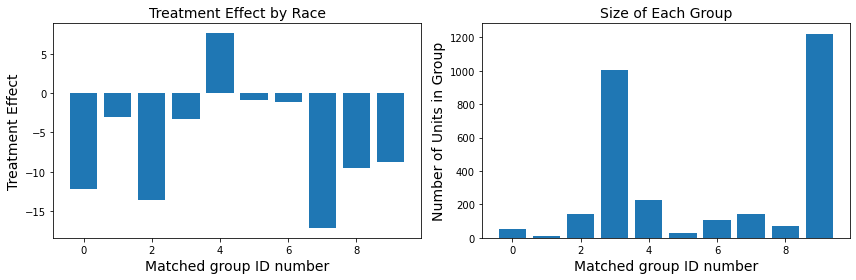

In [165]:
f, ax = plt.subplots(1, 2, gridspec_kw = {'width_ratios':[1, 1]}, figsize=(12,4))
ax[0].set_ylabel('Treatment Effect', fontsize=14)
ax[0].set_xlabel('Matched group ID number', fontsize=14)
ax[0].set_title('Treatment Effect by Race', fontsize=14)
ax[0].bar(groups,cate_of_group)

ax[1].set_ylabel('Number of Units in Group', fontsize=14) # each unit is a sale purchase
ax[1].set_xlabel('Matched group ID number', fontsize=14)
ax[1].set_title('Size of Each Group', fontsize=14)
ax[1].bar(groups,len_group)

plt.tight_layout()

In [164]:
# For each unit, we can see the covariates it was matched on.
model_flame_race.df_units_and_covars_matched[:100]

,RaceDesc_American Indian or Alaska Native,RaceDesc_Asian,RaceDesc_Black or African American,RaceDesc_Hispanic or Latino,RaceDesc_Multi-Racial,RaceDesc_Native Hawaiian or Other Pacific Islander,RaceDesc_Not Specified,RaceDesc_Other,RaceDesc_White
0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,0,0,0


## Matching on Agency

In [131]:
agency = phase1_TA_loadings.loc[:, phase1_TA_loadings.columns.isin(['Initial_Load','Amount','CardIssuingAgency_CSO Auburn', 'CardIssuingAgency_CSO Capitol Hill', 'CardIssuingAgency_CSO White Center'])]
agency = agency.loc[:, ~agency.columns.isin(['DateIssuedToCardHolder'])]
agency

,Initial_Load,CardIssuingAgency_CSO Auburn,CardIssuingAgency_CSO Capitol Hill,CardIssuingAgency_CSO White Center,Amount
0,0,0,0,1,0.0
1,1,0,1,0,0.0
2,0,0,1,0,10.0
3,0,0,0,1,20.0
4,0,0,0,1,15.0
...,...,...,...,...,...
3006,0,0,0,1,16.0
3007,0,0,0,1,10.0
3008,0,0,1,0,0.0
3009,0,0,1,0,0.0


In [134]:
# Matching on agency.
model_flame_agency = dame_flame.matching.FLAME(repeats=True, verbose=3, early_stop_iterations=30, stop_unmatched_t=True, adaptive_weights='ridge', alpha=0.1, want_pe=True)
model_flame_agency.fit(holdout_data=False, treatment_column_name='Initial_Load', outcome_column_name='Amount')
result_agency = model_flame_agency.predict(agency)

Iteration number:  1
	Number of matched groups formed in total:  3
	Unmatched treated units:  0 out of a total of  348 treated units
	Unmatched control units:  0 out of a total of  2663 control units
	Predictive error of covariates chosen this iteration:  0
	Number of matches made in this iteration:  3011
	Number of matches made so far:  3011
	In this iteration, the covariates dropped are:  set()
3011 units matched. We finished with no more treated units to match


In [154]:
mmg3 = dame_flame.utils.post_processing.MG(model_flame_agency, unit_ids =0) # main matched group for unit k.
mmg3

,Initial_Load,CardIssuingAgency_CSO Auburn,CardIssuingAgency_CSO Capitol Hill,CardIssuingAgency_CSO White Center,Amount
0,0,0,0,1,0.0
3,0,0,0,1,20.0
4,0,0,0,1,15.0
5,0,0,0,1,15.0
6,0,0,0,1,20.0
...,...,...,...,...,...
3002,0,0,0,1,20.0
3003,0,0,0,1,30.0
3004,0,0,0,1,30.0
3006,0,0,0,1,16.0


In [138]:
# For each unit, we can see the covariates it was matched on.
model_flame_agency.df_units_and_covars_matched[:100]

,CardIssuingAgency_CSO Auburn,CardIssuingAgency_CSO Capitol Hill,CardIssuingAgency_CSO White Center
0,0,0,1
1,0,1,0
2,0,1,0
3,0,0,1
4,0,0,1
...,...,...,...
95,1,0,0
96,1,0,0
97,1,0,0
98,1,0,0


In [149]:
# differential CA treatment effects
cate_CH = dame_flame.utils.post_processing.CATE(model_flame_agency, 1)
print(cate_CH) # North

cate_WC = dame_flame.utils.post_processing.CATE(model_flame_agency, 0)
print(cate_WC)

cate_Auburn = dame_flame.utils.post_processing.CATE(model_flame_agency, 99)
print(cate_Auburn) # Auburn is the southmost among the three: https://en.wikipedia.org/wiki/Auburn,_Washington)

-7.355741983594331
-5.500404643362314
-3.257840098046284


In [144]:
# Number of auburn in treatment group
tt_a = agency[(agency.Initial_Load != 0)]
tt_a["CardIssuingAgency_CSO Auburn"].value_counts() # 97

0    251
1     97
Name: CardIssuingAgency_CSO Auburn, dtype: int64

In [145]:
groups = list(range(len(model_flame_agency.units_per_group)))
cate_of_group = []
len_group = []
for group in model_flame_agency.units_per_group:
    cate_of_group.append(dame_flame.utils.post_processing.CATE(model_flame_agency, group[0]))
    len_group.append(len(group))

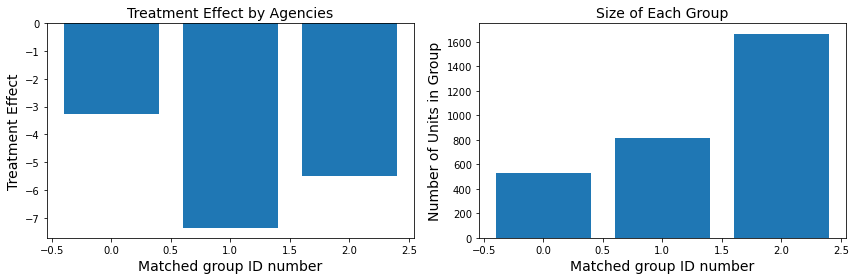

In [155]:
f, ax = plt.subplots(1, 2, gridspec_kw = {'width_ratios':[1, 1]}, figsize=(12,4))
ax[0].set_ylabel('Treatment Effect', fontsize=14)
ax[0].set_xlabel('Matched group ID number', fontsize=14)
ax[0].set_title('Treatment Effect by Agencies', fontsize=14)
ax[0].bar(groups,cate_of_group)

ax[1].set_ylabel('Number of Units in Group', fontsize=14) # each unit is a sale purchase
ax[1].set_xlabel('Matched group ID number', fontsize=14)
ax[1].set_title('Size of Each Group', fontsize=14)
ax[1].bar(groups,len_group)

plt.tight_layout()

## Matching on Age Category

In [167]:
age = phase1_TA_loadings.loc[:, phase1_TA_loadings.columns.isin(['Initial_Load','Amount','Age_bin'])]
age = age.loc[:, ~age.columns.isin(['DateIssuedToCardHolder'])]
age

,Initial_Load,Age_bin,Amount
0,0,3,0.0
1,1,5,0.0
2,0,3,10.0
3,0,4,20.0
4,0,4,15.0
...,...,...,...
3006,0,0,16.0
3007,0,2,10.0
3008,0,4,0.0
3009,0,1,0.0


In [169]:
model_flame_agebin = dame_flame.matching.FLAME(repeats=True, verbose=3, early_stop_iterations=30, stop_unmatched_t=True, adaptive_weights='ridge', alpha=0.1, want_pe=True)
model_flame_agebin.fit(holdout_data=False, treatment_column_name='Initial_Load', outcome_column_name='Amount')
result_agebin = model_flame_agebin.predict(age)

Iteration number:  1
	Number of matched groups formed in total:  6
	Unmatched treated units:  0 out of a total of  348 treated units
	Unmatched control units:  0 out of a total of  2663 control units
	Predictive error of covariates chosen this iteration:  0
	Number of matches made in this iteration:  3011
	Number of matches made so far:  3011
	In this iteration, the covariates dropped are:  set()
3011 units matched. We finished with no more treated units to match


In [180]:
# For each unit, we can see the covariates it was matched on.
# model_flame_agebin.df_units_and_covars_matched[50:60]

In [178]:
cate_0 = dame_flame.utils.post_processing.CATE(model_flame_agebin, 70)
print(cate_0) # 18-25
cate_1 = dame_flame.utils.post_processing.CATE(model_flame_agebin, 50)
print(cate_1)
cate_2 = dame_flame.utils.post_processing.CATE(model_flame_agebin, 99)
print(cate_2)
cate_3 = dame_flame.utils.post_processing.CATE(model_flame_agebin, 0)
print(cate_3)
cate_4 = dame_flame.utils.post_processing.CATE(model_flame_agebin, 3)
print(cate_4)
cate_5 = dame_flame.utils.post_processing.CATE(model_flame_agebin, 1)
print(cate_5) # >65

3.3624088983050857
-7.459517327802264
-7.081674208144797
-8.589622641509434
-7.912111928104576
-12.056603773584905


In [173]:
groups = list(range(len(model_flame_agebin.units_per_group)))
cate_of_group = []
len_group = []
for group in model_flame_agebin.units_per_group:
    cate_of_group.append(dame_flame.utils.post_processing.CATE(model_flame_agebin, group[0]))
    len_group.append(len(group))

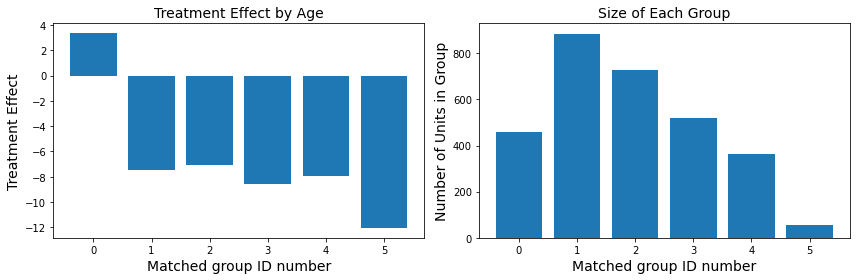

In [174]:
f, ax = plt.subplots(1, 2, gridspec_kw = {'width_ratios':[1, 1]}, figsize=(12,4))
ax[0].set_ylabel('Treatment Effect', fontsize=14)
ax[0].set_xlabel('Matched group ID number', fontsize=14)
ax[0].set_title('Treatment Effect by Age', fontsize=14)
ax[0].bar(groups,cate_of_group)

ax[1].set_ylabel('Number of Units in Group', fontsize=14) # each unit is a sale purchase
ax[1].set_xlabel('Matched group ID number', fontsize=14)
ax[1].set_title('Size of Each Group', fontsize=14)
ax[1].bar(groups,len_group)

plt.tight_layout() # make graph: income by age category.
# age distribution: hispanic population.

Comments: In this analysis, earch unit is a sales purchase. What I could do, is aggregate by card_id s.t. each unit is an individual. (aggregating by person: histogram of number of purchases per individual.)